In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/archive (2)/data/train'

In [ ]:
name_class = os.listdir(file_path)
name_class

['malignant', 'benign']

In [ ]:
from PIL import Image

# Open the image
image_path = '/content/drive/MyDrive/archive (2)/test/malignant/1.jpg'
image = Image.open(image_path)

# Get the size of the image
width, height = image.size

print(f"Image size - Width: {width}, Height: {height}")

Image size - Width: 224, Height: 224


In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [ ]:
filepaths

['/content/drive/MyDrive/archive (2)/data/train/malignant/1241.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/124.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1252.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1226.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1233.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1232.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1237.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1248.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1243.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1222.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1249.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1245.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/1247.jpg',
 '/content/drive/MyDrive/archive (2)/data/train/malignant/125.jpg',
 '/content/drive/MyDrive/archive (2)

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

['malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'mali

In [ ]:
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,/content/drive/MyDrive/archive (2)/data/train/...,benign
1,/content/drive/MyDrive/archive (2)/data/train/...,malignant
2,/content/drive/MyDrive/archive (2)/data/train/...,benign
3,/content/drive/MyDrive/archive (2)/data/train/...,benign
4,/content/drive/MyDrive/archive (2)/data/train/...,malignant


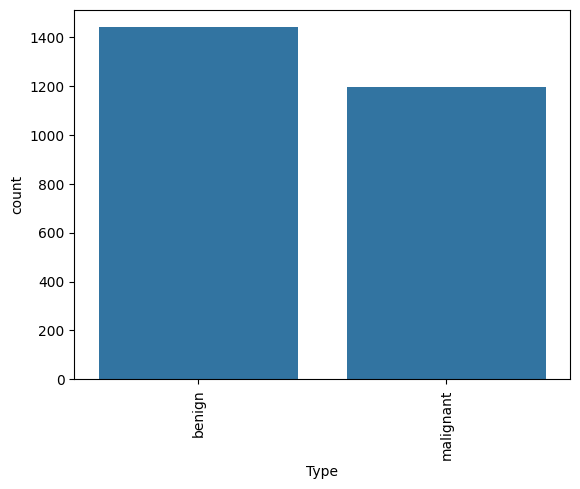

In [ ]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [ ]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [ ]:
# Create data generators with increased data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.


In [ ]:
# Load pre-trained ResNet50 model
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze all layers in the pre-trained model
pretrained_model.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Build the model with reduced complexity and L2 regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(pretrained_model.output)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

In [ ]:
# Use Adam optimizer with a lower learning rate
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define early stopping callback
my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, mode='auto')]

In [ ]:
# Train the model with validation data
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    callbacks=my_callbacks
)

# Access the validation loss and accuracy from the history object
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/50
66/66 [==============================] - 129s 2s/step - loss: 1.6609 - accuracy: 0.8364 - val_loss: 1.6368 - val_accuracy: 0.7992
Epoch 2/50
66/66 [==============================] - 117s 2s/step - loss: 1.5960 - accuracy: 0.8307 - val_loss: 1.5575 - val_accuracy: 0.8087
Epoch 3/50
66/66 [==============================] - 117s 2s/step - loss: 1.5095 - accuracy: 0.8402 - val_loss: 1.4798 - val_accuracy: 0.8258
Epoch 4/50
66/66 [==============================] - 135s 2s/step - loss: 1.4390 - accuracy: 0.8336 - val_loss: 1.4247 - val_accuracy: 0.8144
Epoch 5/50
66/66 [==============================] - 135s 2s/step - loss: 1.3725 - accuracy: 0.8412 - val_loss: 1.3721 - val_accuracy: 0.8087
Epoch 6/50
66/66 [==============================] - 135s 2s/step - loss: 1.3134 - accuracy: 0.8478 - val_loss: 1.2959 - val_accuracy: 0.8352
Epoch 7/50
66/66 [==============================] - 135s 2s/step - loss: 1.2644 - accuracy: 0.8412 - val_loss: 1.2430 - val_accuracy: 0.8277
Epoch 8/50
66

In [ ]:
# Access the validation loss and accuracy from the history object
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Validation Loss: [1.6367605924606323, 1.557539463043213, 1.4798399209976196, 1.4247441291809082, 1.37211012840271, 1.2959026098251343, 1.2430226802825928, 1.1875090599060059, 1.1543439626693726, 1.111069679260254, 1.0524629354476929, 1.036947250366211, 0.9506141543388367, 0.9479785561561584, 0.9331272840499878, 0.9113203883171082, 0.8696370124816895, 0.838019609451294]
Validation Accuracy: [0.7992424368858337, 0.8087121248245239, 0.8257575631141663, 0.814393937587738, 0.8087121248245239, 0.8352272510528564, 0.8276515007019043, 0.8276515007019043, 0.8238636255264282, 0.8314393758773804, 0.8371211886405945, 0.8219696879386902, 0.8465909361839294, 0.8390151262283325, 0.8333333134651184, 0.8333333134651184, 0.8276515007019043, 0.8352272510528564]


In [ ]:
model.save("/content/drive/MyDrive/archive (2)/modell.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Get the count of images after data augmentation for the training set
train_augmented_count = len(train_gen.classes) * train_gen.batch_size

# Get the count of images after data augmentation for the validation set
valid_augmented_count = len(valid_gen.classes) * valid_gen.batch_size

print("Count of images after data augmentation for training set:", train_augmented_count)
print("Count of images after data augmentation for validation set:", valid_augmented_count)

Count of images after data augmentation for training set: 67488
Count of images after data augmentation for validation set: 16896


In [ ]:
# Calculate and print accuracy
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print("\nTest accuracy:", test_acc)

17/17 - 29s - loss: 0.8302 - accuracy: 0.8580 - 29s/epoch - 2s/step

Test accuracy: 0.8579545617103577


17/17 [==============================] - 23s 1s/step


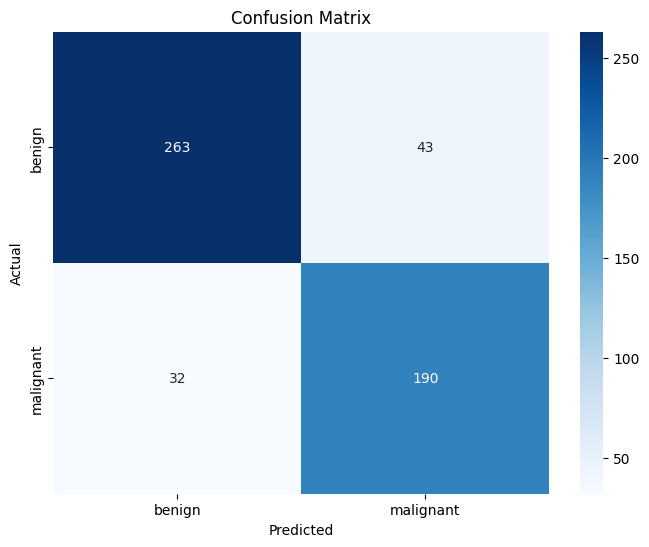

In [ ]:
# Generate predictions on the test set
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels
y_true = test_gen.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

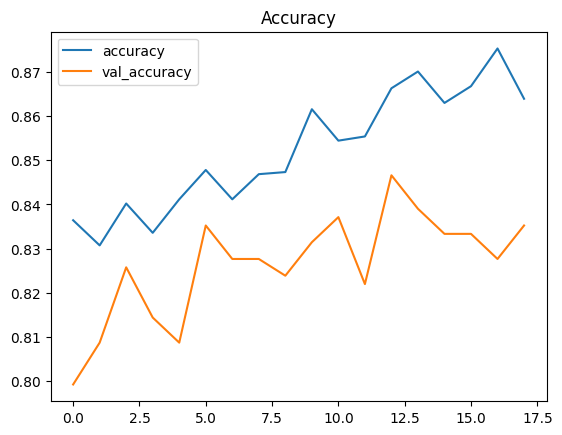

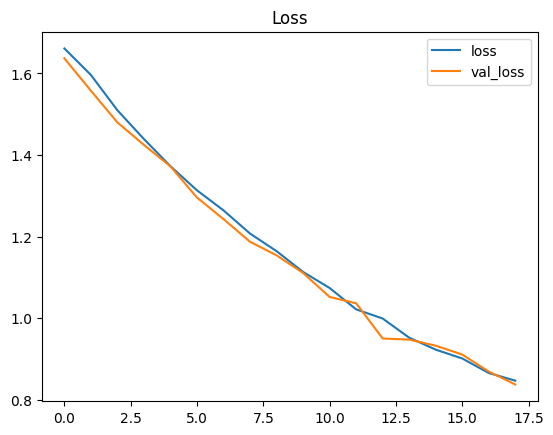

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.83022
Test Accuracy: 85.80%


In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

17/17 [==============================] - 29s 2s/step


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.80%


In [ ]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      benign       0.89      0.86      0.88       306
   malignant       0.82      0.86      0.84       222

    accuracy                           0.86       528
   macro avg       0.85      0.86      0.86       528
weighted avg       0.86      0.86      0.86       528



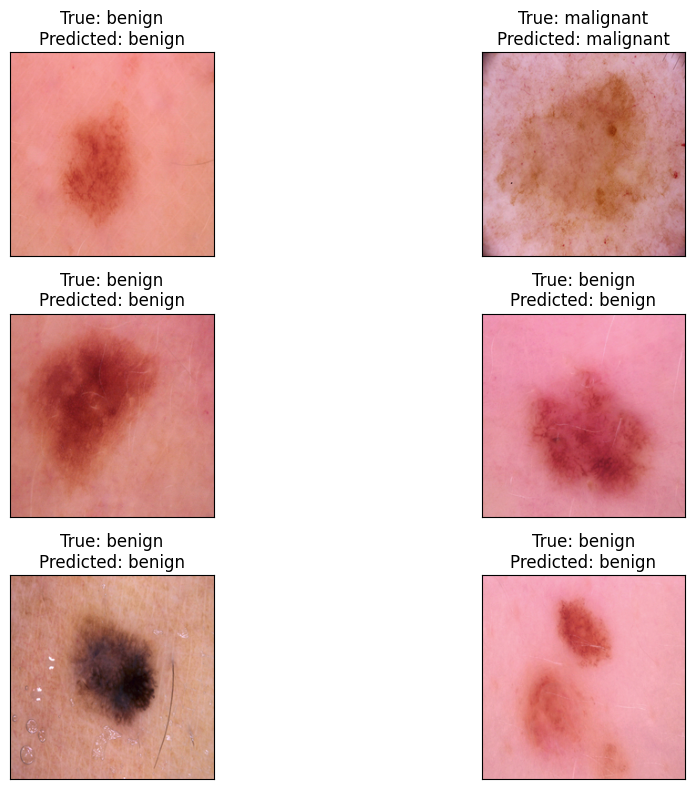

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/archive (2)/modell.h5')

In [ ]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '/content/drive/MyDrive/archive (2)/test/malignant/real2.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
result = model.predict(x)
print((result*100).astype('int'))

#print('Input image shape:', x.shape)

#my_image = imread(img_path)
#imshow(my_image)

1/1 [==============================] - 1s 1s/step
[[ 5 94]]


In [ ]:
from tensorflow.keras.models import load_model
loaded_model_imageNet = load_model("/content/drive/MyDrive/archive (2)/modell.h5")
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '/content/drive/MyDrive/archive (2)/test/malignant/real2.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
result = loaded_model_imageNet.predict(x)
print((result*100).astype('int'))

#print('Input image shape:', x.shape)

#my_image = imread(img_path)
#imshow(my_image)

1/1 [==============================] - 1s 1s/step
[[ 5 94]]


In [ ]:
p=list((result*100).astype('int'))
pp=list(p[0])
print(pp)

[5, 94]


In [ ]:
print("Largest element is:", max(pp))

Largest element is: 94


In [ ]:
index = pp.index(max(pp))

In [ ]:
name_class=['benign', 'Melignant']

In [ ]:
name_class[index]

'Melignant'

In [ ]:
plt.imread(img_path)

array([[[239, 163, 105],
        [238, 162, 104],
        [238, 162, 104],
        ...,
        [210, 146, 118],
        [208, 144, 116],
        [207, 143, 115]],

       [[243, 167, 109],
        [242, 166, 108],
        [241, 165, 107],
        ...,
        [210, 146, 118],
        [207, 143, 115],
        [205, 141, 113]],

       [[249, 170, 113],
        [247, 168, 111],
        [245, 166, 109],
        ...,
        [208, 144, 116],
        [203, 139, 111],
        [200, 136, 108]],

       ...,

       [[197, 136,  92],
        [198, 137,  93],
        [198, 137,  92],
        ...,
        [172, 104,  59],
        [169, 101,  56],
        [168, 100,  55]],

       [[192, 131,  86],
        [195, 134,  89],
        [197, 136,  91],
        ...,
        [174, 106,  61],
        [170, 101,  59],
        [167,  98,  56]],

       [[194, 133,  88],
        [199, 138,  93],
        [201, 140,  95],
        ...,
        [177, 109,  64],
        [174, 105,  63],
        [171, 102,  60]]

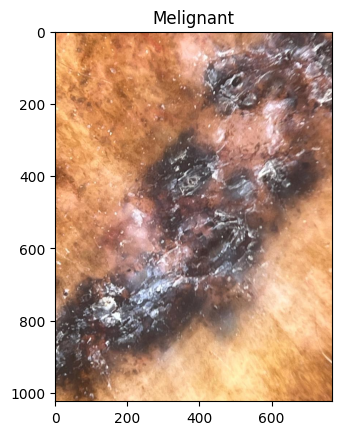

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title(name_class[index])
plt.show()